In [1]:
from xopt import Xopt
from xopt.utils import read_xopt_csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from pmd_beamphysics import ParticleGroup, particle_paths, single_particle
from pmd_beamphysics.plot import density_plot
from distgen import Generator
import yaml
import pandas as pd
from glob import glob

In [4]:
OUTPUT_PATH = "cav_run2_20250714/"
#OUTPUT_PATH = "temp/"

In [5]:
# find all popolation files and sort by generation
pop_files = sorted(glob(OUTPUT_PATH + "cnsga_population*"))
len(pop_files)

20

In [6]:
# Read all population files and combine into one dataframe
all_populations = []
for i, file in enumerate(pop_files):
    df = read_xopt_csv(file)
    df['generation'] = i
    all_populations.append(df)

# Combine all generations
pop_df = pd.concat(all_populations, ignore_index=True)
print(f"Total evaluations: {len(pop_df)}")
print(f"Number of generations: {pop_df['generation'].nunique()}")
pop_df.head()

Total evaluations: 1280
Number of generations: 20


,phase,phase3,voltage,voltage3,gamma_error,energy_spread,sigma_energy,mean_gamma,n_alive_ratio,ID,xopt_runtime,xopt_error,generation
0,-0.029939,0.422289,868738.517194,441768.613157,0.000003,0.002864,37231.684018,25.440316,1.0,1892cd391f735dd6fb375c99d76352d2,8771.437288,False,0
1,0.029184,0.588197,805436.548466,382596.158749,0.002953,0.000913,11202.684668,24.019794,1.0,f8e97c1ec907bab9f03939cdc763793d,8816.884482,False,0
2,-0.015049,0.455177,787744.721407,372424.268208,0.005418,0.000664,7979.017767,23.530338,1.0,eafd30acf67681932b243e81bfc4b1ac,9241.096549,False,0
3,-0.045637,0.484448,891407.366528,425910.656612,0.000027,0.032597,420881.948811,25.267178,1.0,f3e1c0d30f555b8a87122eb6c59b94cb,8093.687206,False,0
4,0.014092,0.554381,845099.482612,400624.967701,0.000067,0.004178,53782.281154,25.191516,1.0,e85ebcc1cf8d08a5122637ebf9c00ef9,8213.221676,False,0


In [7]:
# Define variables and objectives
variables = ['phase', 'phase3', 'voltage', 'voltage3']
objectives = ['gamma_error', 'energy_spread']

print("Variables:", variables)
print("Objectives:", objectives)
print("\nData ranges:")
for var in variables:
    print(f"{var}: [{pop_df[var].min():.6f}, {pop_df[var].max():.6f}]")
for obj in objectives:
    print(f"{obj}: [{pop_df[obj].min():.2e}, {pop_df[obj].max():.2e}]")

Variables: ['phase', 'phase3', 'voltage', 'voltage3']
Objectives: ['gamma_error', 'energy_spread']

Data ranges:
phase: [-0.099360, 0.099487]
phase3: [0.402252, 0.599227]
voltage: [750551.063897, 898596.512454]
voltage3: [300010.074565, 499262.793033]
gamma_error: [5.91e-11, 9.09e-02]
energy_spread: [3.36e-04, 1.86e-01]


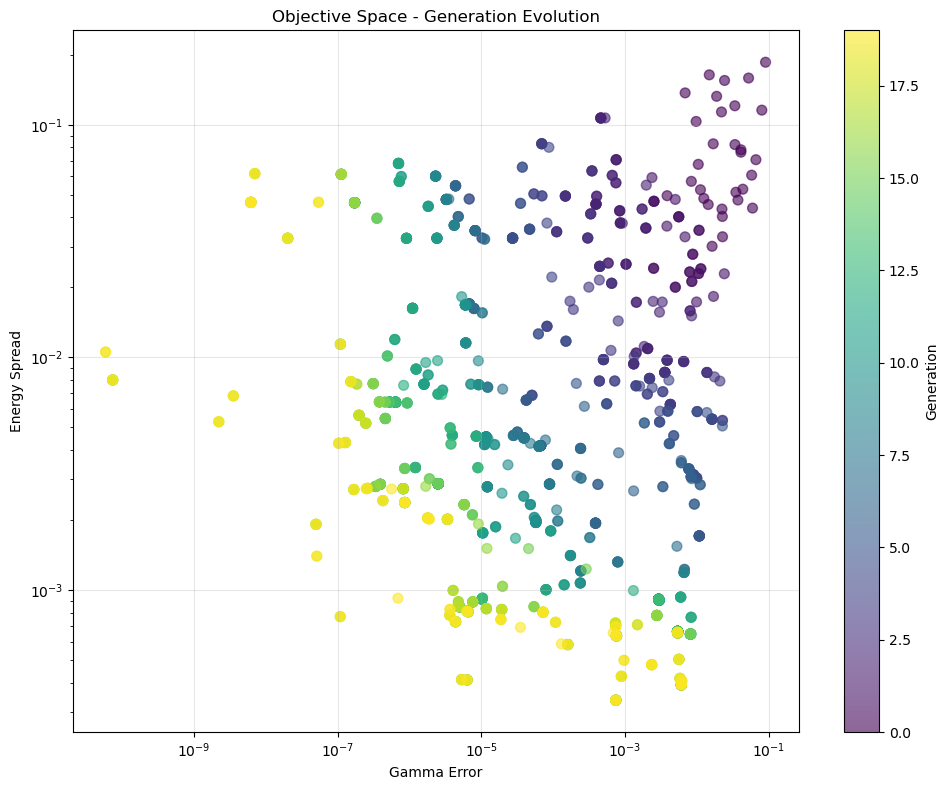

In [8]:
# 2. Objective space plot (Pareto front)
fig, ax = plt.subplots(figsize=(10, 8))

# Create scatter plot with color based on generation
scatter = ax.scatter(pop_df['gamma_error'], pop_df['energy_spread'], 
                    c=pop_df['generation'], cmap='viridis', alpha=0.6, s=50)

ax.set_xlabel('Gamma Error')
ax.set_ylabel('Energy Spread')
ax.set_title('Objective Space - Generation Evolution')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Generation')

plt.tight_layout()
plt.show()

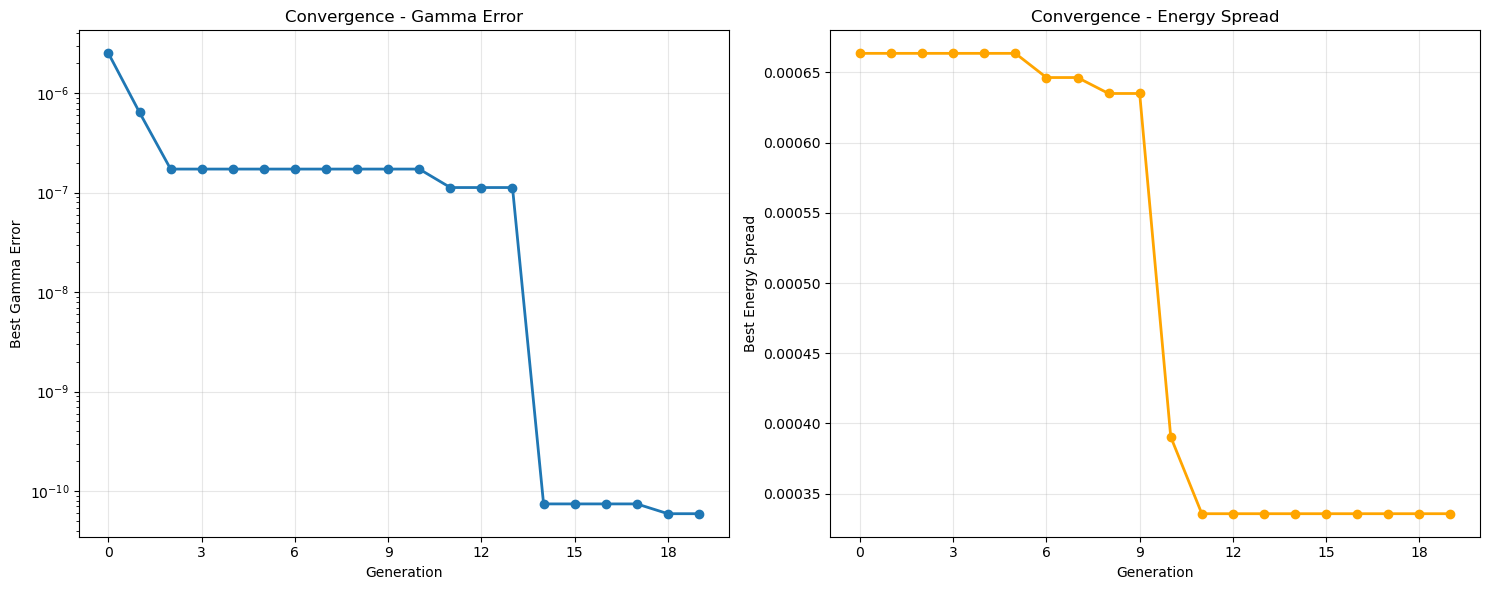

In [7]:
# 3. Convergence analysis - Best objectives over generations
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Calculate best values per generation
best_per_gen = pop_df.groupby('generation').agg({
    'gamma_error': 'min',
    'energy_spread': 'min'
}).reset_index()

# Plot convergence
axes[0].plot(best_per_gen['generation'], best_per_gen['gamma_error'], 'o-', linewidth=2, markersize=6)
axes[0].set_xlabel('Generation')
axes[0].set_ylabel('Best Gamma Error')
axes[0].set_title('Convergence - Gamma Error')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)
# Force integer x-ticks
axes[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

axes[1].plot(best_per_gen['generation'], best_per_gen['energy_spread'], 'o-', linewidth=2, markersize=6, color='orange')
axes[1].set_xlabel('Generation')
axes[1].set_ylabel('Best Energy Spread')
axes[1].set_title('Convergence - Energy Spread')
axes[1].grid(True, alpha=0.3)
# Force integer x-ticks
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

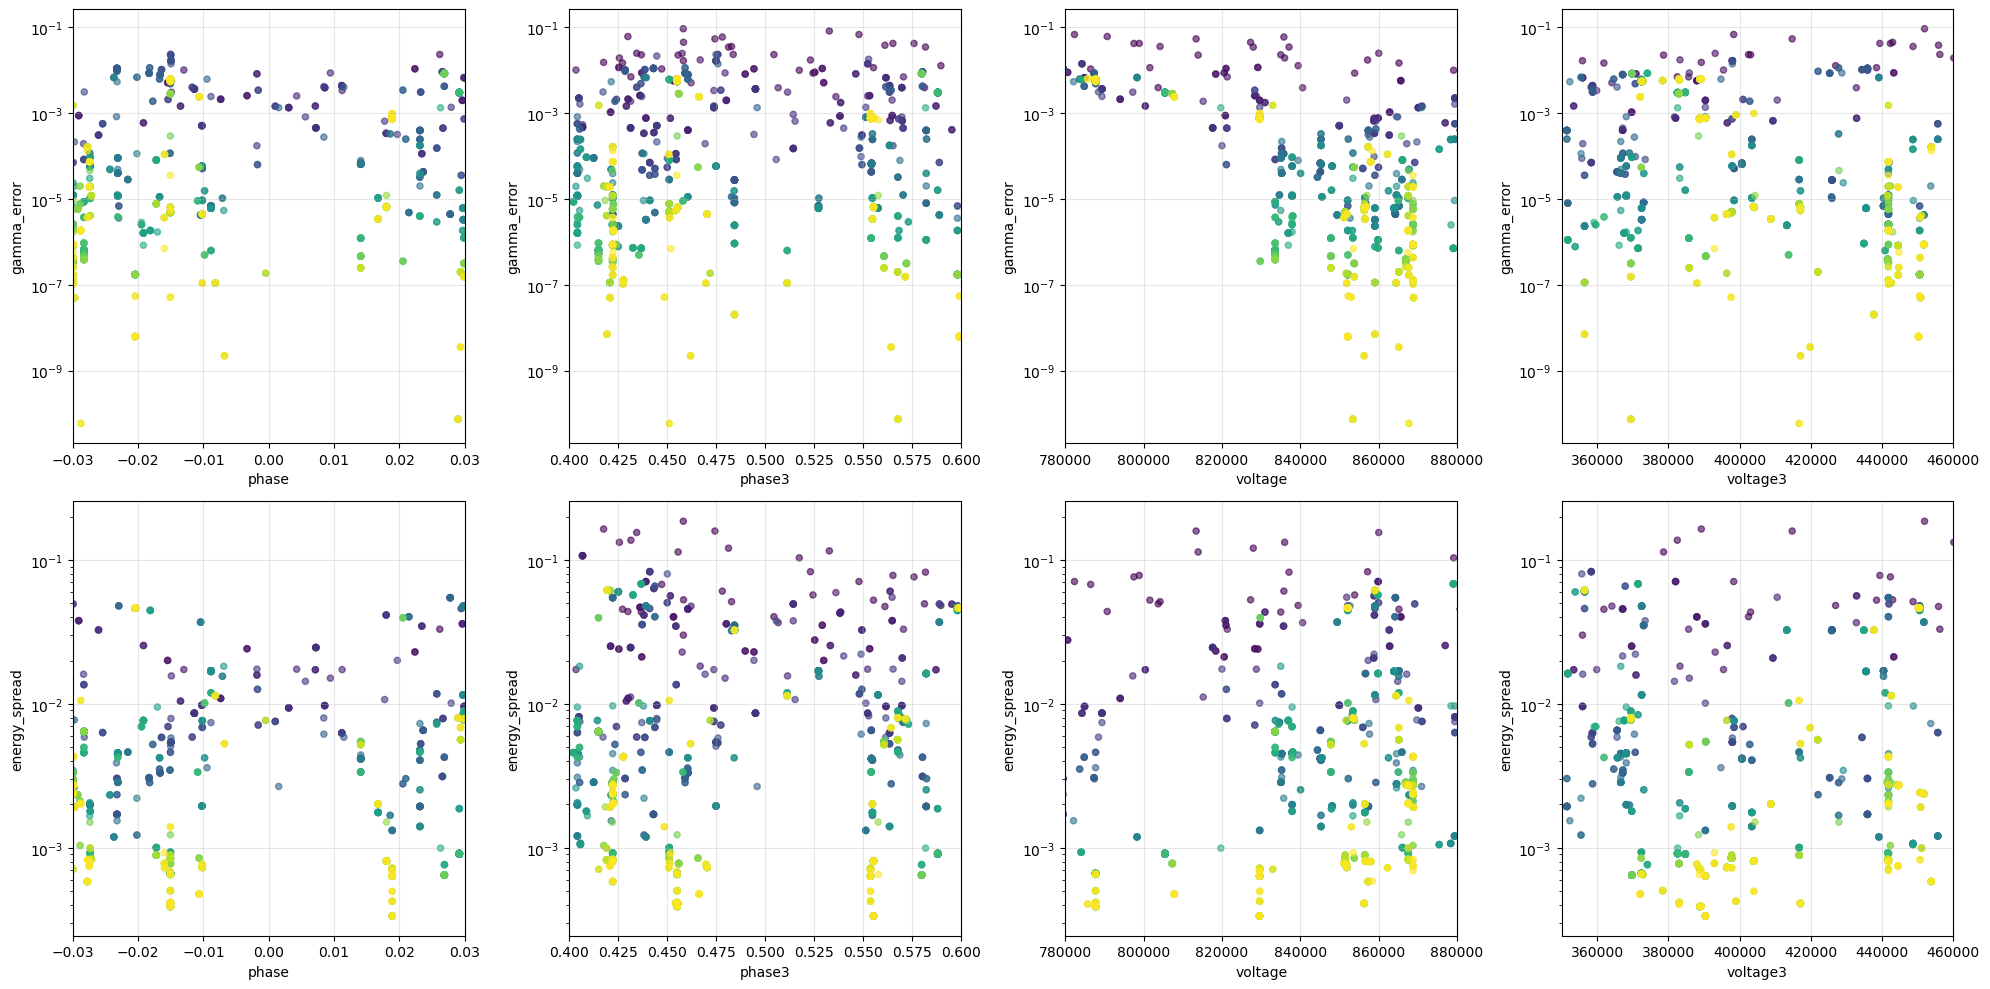

In [23]:
# 5. Variable vs Objective relationships
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, var in enumerate(variables):
    for j, obj in enumerate(objectives):
        ax = axes[j, i]
        ax.scatter(pop_df[var], pop_df[obj], alpha=0.6, s=20, c=pop_df['generation'], cmap='viridis')
        ax.set_xlabel(var)
        ax.set_ylabel(obj)
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)
        if var == 'phase':
            ax.set_xlim(-0.03, 0.03)
        elif var == 'phase3':
            ax.set_xlim(0.4, 0.6)
        elif var == 'voltage':
            ax.set_xlim(780e3, 880e3)
        elif var == 'voltage3':
            ax.set_xlim(350e3, 460e3)

plt.tight_layout()
plt.show()

In [9]:
# 6. Find and analyze the best solutions
print("=== BEST SOLUTIONS ANALYSIS ===")

# Remove duplicates based on ID (keep first occurrence)
pop_df_unique = pop_df.drop_duplicates(subset=['ID'], keep='first')
print(f"Original solutions: {len(pop_df)}")
print(f"Unique solutions (after removing duplicates): {len(pop_df_unique)}")

# Find Pareto optimal solutions (non-dominated)
def is_dominated(row, df):
    """Check if a solution is dominated by any other solution"""
    for _, other_row in df.iterrows():
        if (other_row['gamma_error'] <= row['gamma_error'] and 
            other_row['energy_spread'] <= row['energy_spread'] and
            (other_row['gamma_error'] < row['gamma_error'] or 
             other_row['energy_spread'] < row['energy_spread'])):
            return True
    return False

# Find non-dominated solutions from unique dataset
pareto_front = []
for idx, row in pop_df_unique.iterrows():
    if not is_dominated(row, pop_df_unique):
        pareto_front.append(row)

pareto_df = pd.DataFrame(pareto_front)
print(f"Number of Pareto optimal solutions: {len(pareto_df)}")

=== BEST SOLUTIONS ANALYSIS ===
Original solutions: 1280
Unique solutions (after removing duplicates): 342


Number of Pareto optimal solutions: 10


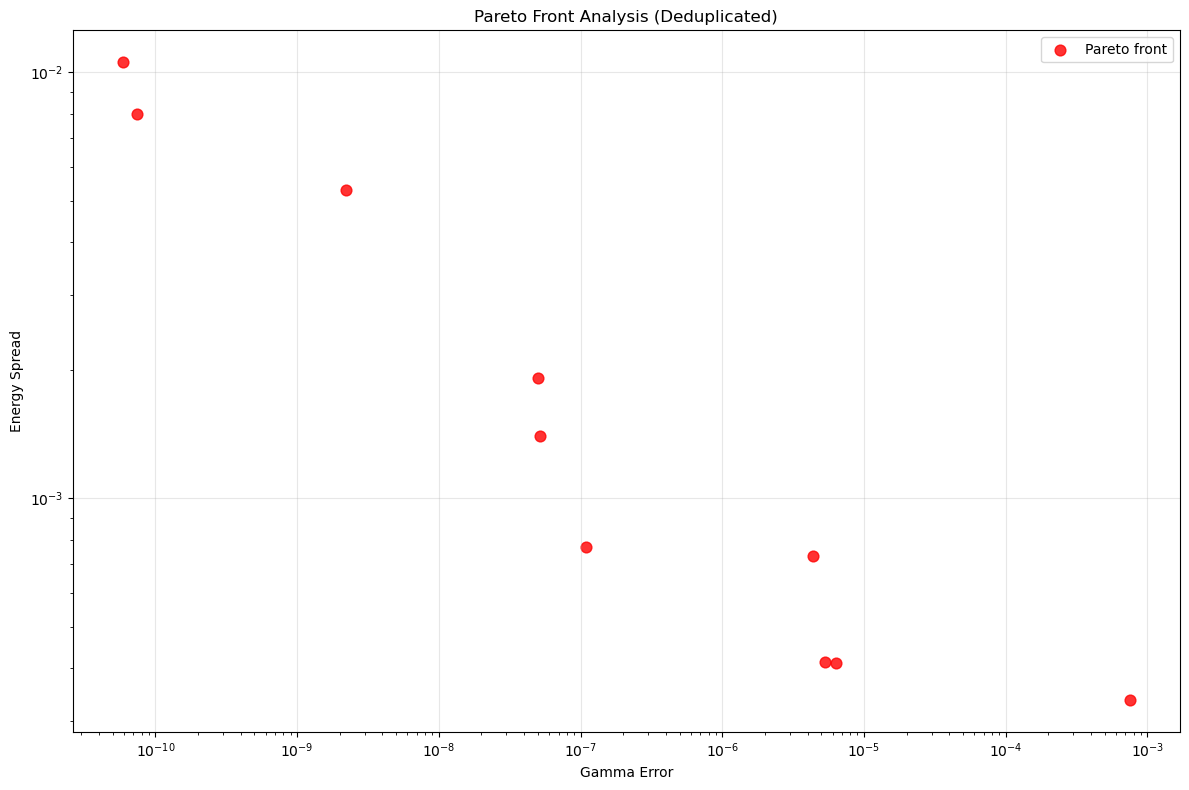

In [10]:
# 7. Plot Pareto front with best solutions highlighted
fig, ax = plt.subplots(figsize=(12, 8))

# All unique solutions
#ax.scatter(pop_df_unique['gamma_error'], pop_df_unique['energy_spread'], 
#          alpha=0.3, s=30, c='lightblue', label='All unique solutions')

# Pareto front
ax.scatter(pareto_df['gamma_error'], pareto_df['energy_spread'], 
          alpha=0.8, s=60, c='red', label='Pareto front')

ax.set_xlabel('Gamma Error')
ax.set_ylabel('Energy Spread')
ax.set_title('Pareto Front Analysis (Deduplicated)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

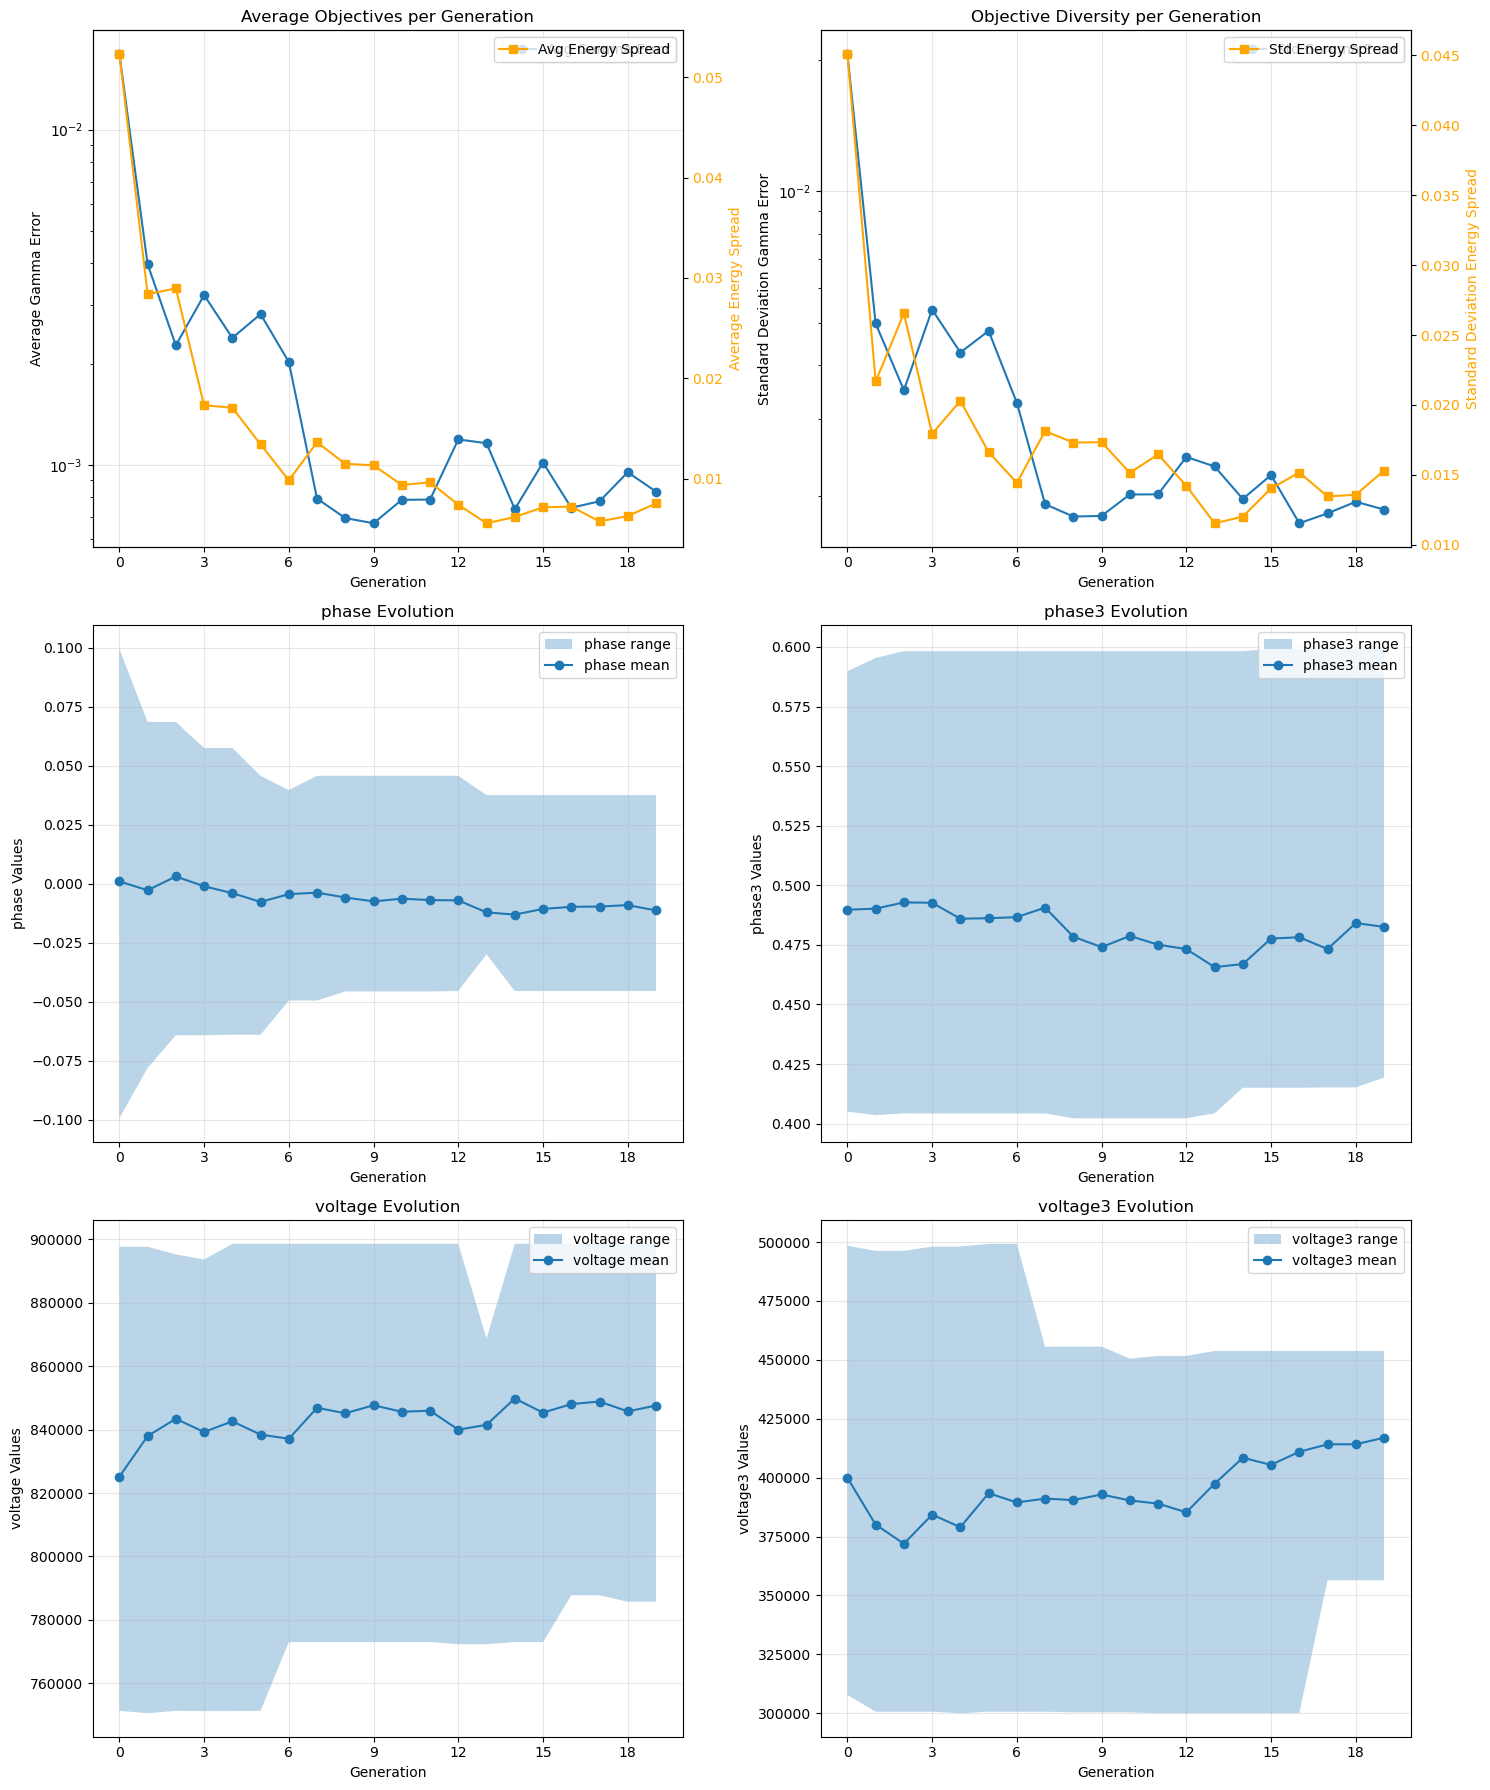

In [11]:
# 8. Generation-wise analysis
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Average objectives per generation
avg_obj = pop_df.groupby('generation')[objectives].mean()
axes[0,0].plot(avg_obj.index, avg_obj['gamma_error'], 'o-', label='Avg Gamma Error')
axes[0,0].set_xlabel('Generation')
axes[0,0].set_ylabel('Average Gamma Error')
axes[0,0].set_yscale('log')
axes[0,0].set_title('Average Objectives per Generation')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend()
axes[0,0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

ax2 = axes[0,0].twinx()
ax2.plot(avg_obj.index, avg_obj['energy_spread'], 's-', color='orange', label='Avg Energy Spread')
ax2.set_ylabel('Average Energy Spread', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

# Standard deviation of objectives per generation
std_obj = pop_df.groupby('generation')[objectives].std()
axes[0,1].plot(std_obj.index, std_obj['gamma_error'], 'o-', label='Std Gamma Error')
axes[0,1].set_xlabel('Generation')
axes[0,1].set_ylabel('Standard Deviation Gamma Error')
axes[0,1].set_yscale('log')
axes[0,1].set_title('Objective Diversity per Generation')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].legend()
axes[0,1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

ax3 = axes[0,1].twinx()
ax3.plot(std_obj.index, std_obj['energy_spread'], 's-', color='orange', label='Std Energy Spread')
ax3.set_ylabel('Standard Deviation Energy Spread', color='orange')
ax3.tick_params(axis='y', labelcolor='orange')
ax3.legend(loc='upper right')

# Individual variable evolution - each variable gets its own plot
var_positions = [axes[1,0], axes[1,1], axes[2,0], axes[2,1]]

for i, var in enumerate(variables):
    var_stats = pop_df.groupby('generation')[var].agg(['min', 'max', 'mean'])
    ax = var_positions[i]
    
    ax.fill_between(var_stats.index, var_stats['min'], var_stats['max'], 
                   alpha=0.3, label=f'{var} range')
    ax.plot(var_stats.index, var_stats['mean'], 'o-', label=f'{var} mean')
    ax.set_xlabel('Generation')
    ax.set_ylabel(f'{var} Values')
    ax.set_title(f'{var} Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

In [19]:
# 9. Select solutions from Pareto front and read particle data
print("=== PARETO FRONT SOLUTIONS ===")
print(f"Number of Pareto optimal solutions: {len(pareto_df)}")

# Display Pareto front solutions with their IDs
print("\nPareto front solutions:")

# Best solutions
best_gamma = pareto_df.sort_values(by=['gamma_error', 'energy_spread'])
best_energy = pareto_df.sort_values(by=['energy_spread', 'gamma_error'])

pareto_display = best_gamma[['ID', 'mean_gamma'] + objectives]
#pareto_display_energy = best_energy[['ID', 'mean_gamma'] + objectives]
pd.set_option('display.expand_frame_repr', False)
print(pareto_display)
#print(pareto_display_energy.head())


=== PARETO FRONT SOLUTIONS ===
Number of Pareto optimal solutions: 10

Pareto front solutions:
                                    ID  mean_gamma   gamma_error  energy_spread
1161  c6242c344c7f3ca20749401dc330da66   25.400195  5.905285e-11       0.010558
904   2bb3ca6c0a7bcdad5fac0f582bd375d0   25.400219  7.408998e-11       0.008003
1094  878ece7ee9cfae2975dd8e64daa8d373   25.398802  2.224247e-09       0.005290
964   51250ab3a29f6c0054a7c267b9cea8a7   25.405688  5.014100e-08       0.001916
1162  1f2bf21e61e7c3e1aeb563a3d9ee52ff   25.405760  5.142205e-08       0.001398
1095  198026489da52babc6cd0dfedd483eb0   25.408393  1.091847e-07       0.000768
708   6fd82387b2214c4c682151e9017b6e0c   25.346787  4.389010e-06       0.000731
965   419f0a1507ba95be88e33fc3ce3091fd   25.341310  5.338986e-06       0.000412
842   39e8d92c8ad631a45b6162d51de51d24   25.335845  6.379679e-06       0.000410
711   b9ff479a2d04c7b27e821ad6bf8ec6f2   24.704618  7.495128e-04       0.000336


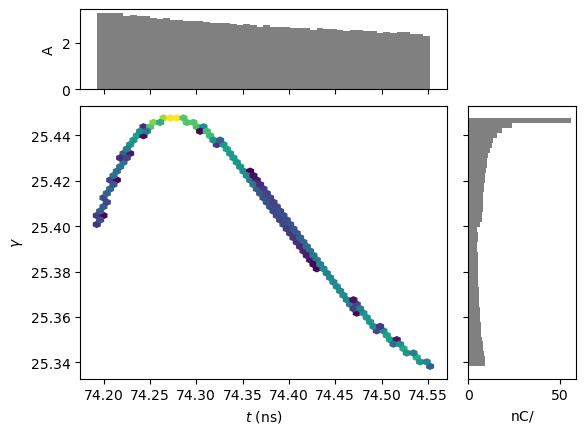

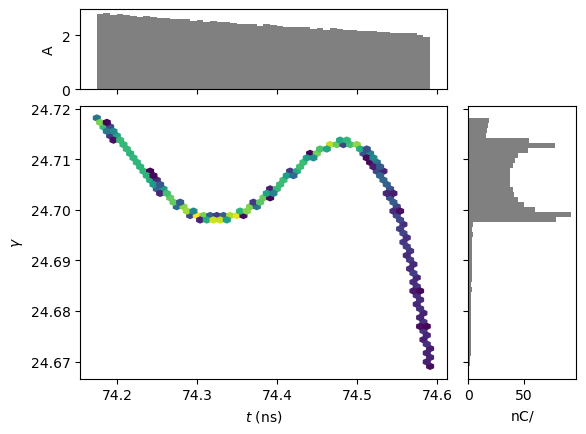

In [15]:
selected_ID = ["1f2bf21e61e7c3e1aeb563a3d9ee52ff", "b9ff479a2d04c7b27e821ad6bf8ec6f2"]
pgs = []
#global_y_limits = (25, 25.6)
for i, ID in enumerate(selected_ID):    
    # Read particle data
    pg = ParticleGroup(OUTPUT_PATH + ID + ".h5")
    pgs.append(pg)
    pg.plot('t', 'gamma')

In [20]:
best_id = "b9ff479a2d04c7b27e821ad6bf8ec6f2"
row = pop_df[pop_df['ID'] == best_id]
if not row.empty:
    print(row[['phase', 'phase3', 'voltage', 'voltage3']])
else:
    print("ID not found!")

         phase    phase3       voltage       voltage3
711   0.018908  0.555417  829549.57148  390380.399835
775   0.018908  0.555417  829549.57148  390380.399835
839   0.018908  0.555417  829549.57148  390380.399835
900   0.018908  0.555417  829549.57148  390380.399835
961   0.018908  0.555417  829549.57148  390380.399835
1025  0.018908  0.555417  829549.57148  390380.399835
1089  0.018908  0.555417  829549.57148  390380.399835
1153  0.018908  0.555417  829549.57148  390380.399835
1154  0.018908  0.555417  829549.57148  390380.399835
1218  0.018908  0.555417  829549.57148  390380.399835
1219  0.018908  0.555417  829549.57148  390380.399835


In [63]:
pgs[idx]['mean_energy']

12978561.270497521